In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

!pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.2 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 39.3 MB/s eta 0:00:00
  Pr

In [3]:
%matplotlib inline
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import dgl.function as fn
import torch.nn.functional as F
import shutil
from torch.utils.data import DataLoader
import cloudpickle
from dgl.nn import GraphConv
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [4]:
current_dir = "/content/drive/MyDrive/GML Final Project/"
checkpoint_path = current_dir + "save_models/model_checkpoints/" + "checkpoint"
os.makedirs(checkpoint_path, exist_ok=True)

best_model_path = current_dir + "save_models/best_model/"

folder_data_temp = current_dir +"data_temp/"
shutil.rmtree(folder_data_temp, ignore_errors=True)

path_save = current_dir + "Lipophilicity.zip"
shutil.unpack_archive(path_save, folder_data_temp)

In [5]:
""" Regression Dataset """
class DGLDatasetReg(torch.utils.data.Dataset):
    def __init__(self, address, train=False, scaler=None):
            self.train = train
            self.scaler = scaler
            self.data_set, train_labels_globals = dgl.load_graphs(address+".bin")
            num_graphs = len(self.data_set)

            self.labels = train_labels_globals["labels"]
            self.globals = train_labels_globals["globals"]


    def scaler_method(self):
        if self.train:
            scaler = preprocessing.StandardScaler().fit(self.labels)
            self.scaler = scaler
        return self.scaler

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        return  self.data_set[idx], self.labels[idx].float(), self.globals[idx]


In [6]:
scaler = {}
path_data_temp = folder_data_temp + "scaffold"+"_"+str(0)
train_set = DGLDatasetReg(address=path_data_temp+"_train", train=True)
scaler = train_set.scaler_method()
val_set = DGLDatasetReg(address=path_data_temp+"_val", scaler=scaler)
test_set = DGLDatasetReg(address=path_data_temp+"_test", scaler=scaler)

print(len(train_set), len(val_set), len(test_set))


3360 420 420


In [7]:
def collate(batch):
    # batch is a list of tuples (graphs, labels, globals)
    # Concatenate a sequence of graphs
    graphs = [e[0] for e in batch]
    g = dgl.batch(graphs)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[1] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (globals) along a new dimension
    globals = [e[2] for e in batch]
    globals = torch.stack(globals, 0)

    return g, labels, globals


def loader(batch_size=64):
    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=True,
                              shuffle=True,
                              num_workers=1)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=True,
                             shuffle=False,
                             num_workers=1)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=True,
                             shuffle=False,
                             num_workers=1)
    return train_dataloader, val_dataloader, test_dataloader

In [8]:
train_dataloader, val_dataloader, test_dataloader = loader(batch_size=64)

In [9]:
# Dataset Summary
train_set_length = len(train_set)
val_set_length = len(val_set)
test_set_length = len(test_set)

node_feature_size = train_set.data_set[0].ndata['v'].shape[1]
edge_feature_size = train_set.data_set[0].edata['e'].shape[1]

num_labels = train_set.labels.shape[1]  # Assuming multiple regression targets

print("Dataset Summary:")
print("Training Set Length:", train_set_length)
print("Validation Set Length:", val_set_length)
print("Test Set Length:", test_set_length)
print("Node Feature Size:", node_feature_size)
print("Edge Feature Size:", edge_feature_size)
print("Number of Labels:", num_labels)


Dataset Summary:
Training Set Length: 3360
Validation Set Length: 420
Test Set Length: 420
Node Feature Size: 128
Edge Feature Size: 13
Number of Labels: 1


Summary Statistics:
Mean: tensor([2.2168])
Median: tensor([2.4000])
Standard Deviation: tensor([1.1927])
Minimum Value: tensor([-1.5000])
Maximum Value: tensor([4.5000])


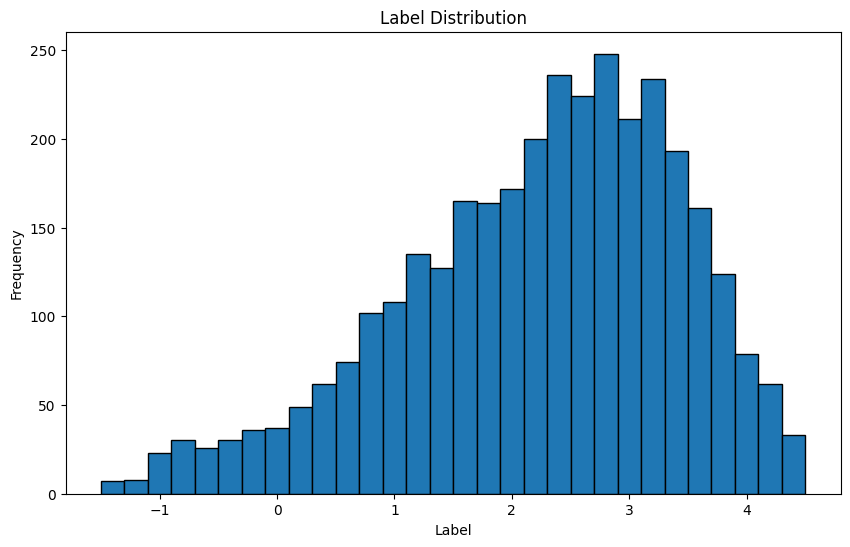

In [10]:
import matplotlib.pyplot as plt

# Statistical Analysis
labels = train_set.labels

# Summary Statistics
mean = torch.mean(labels, dim=0)
median = torch.median(labels, dim=0).values
std = torch.std(labels, dim=0)
min_val = torch.min(labels, dim=0).values
max_val = torch.max(labels, dim=0).values

print("Summary Statistics:")
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

# Label Distribution
plt.figure(figsize=(10, 6))
plt.hist(labels[:, 0], bins=30, edgecolor='black')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Label Distribution")
plt.show()


In [11]:
# Combine graphs in the training set into a single graph
graph_list = train_set.data_set
combined_graph = dgl.batch(graph_list)

In [12]:
combined_graph.number_of_nodes()

32813

In [13]:
combined_graph.number_of_edges()

63860

In [14]:
combined_graph.edges()

(tensor([    0,     1,     1,  ..., 32810, 32811, 32812], dtype=torch.int32),
 tensor([    1,     0,     2,  ..., 32809, 32809, 32809], dtype=torch.int32))

In [15]:
# Size of global feature of each graph
global_size = 200

# Number of epochs to train the model
num_epochs = 100

# Number of steps to wait if the model performance on the validation set does not improve
patience = 10

#Configurations to instantiate the model
config = {"node_feature_size":127, "edge_feature_size":12, "hidden_size":100}


# innovation module 1

In [16]:
dgl.use_libxsmm(False)

class CustomModule(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(CustomModule, self).__init__()

        self.linear1 = nn.Linear(in_feat * 2, 256)
        self.linear2 = nn.Linear(256, out_feat)
        self.relu = nn.ReLU()

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.update_all(
                message_func=fn.copy_u('h', 'm'),
                reduce_func=fn.max("m", "A"),
            )
            A = g.ndata["A"]
            concat = torch.cat([h, A], dim=1)
            output = self.linear1(concat)
            output = self.relu(output)
            output = self.linear2(output)
            output = self.relu(output)
            return output


In [17]:
class GNN(nn.Module):
    def __init__(self, config, global_size=200):
        super().__init__()
        self.config = config


        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.Custom1 = CustomModule(self.node_feature_size, self.hidden_size)
        self.Custom2 = CustomModule(self.hidden_size, self.hidden_size)
        self.Custom3 = CustomModule(self.hidden_size, self.hidden_size)
        self.Custom4 = CustomModule(self.hidden_size, 1)

    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"] = mol_dgl_graph.ndata["v"][:, :self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:, :self.edge_feature_size]

        h = mol_dgl_graph.ndata["v"]
        h = self.Custom1(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom2(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom3(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom4(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")


In [18]:
import math

def compute_score(model, data_loader, scaler, val_size):
  model.eval()
  loss_sum = nn.MSELoss(reduction='sum') # MSE with sum instead of mean, i.e., sum_i[(y_i)^2-(y'_i)^2]
  final_loss = 0
  state = torch.get_rng_state()
  with torch.no_grad():
    for i, (mol_dgl_graph, labels, globals) in enumerate(data_loader):
       prediction = model(mol_dgl_graph, globals)
       prediction = torch.tensor(scaler.inverse_transform(prediction.detach().cpu()))
       labels = torch.tensor(scaler.inverse_transform(labels.cpu()))
       loss = loss_sum(prediction, labels)
       final_loss += loss.item()

    final_loss /= val_size
    final_loss = math.sqrt(final_loss)

  return final_loss

In [19]:
def loss_func(output, label):
    criterion = nn.MSELoss(reduction='mean')  # Use reduction='mean' instead of 'none'
    loss = criterion(output, label)
    return loss

In [20]:
def train_epoch(train_dataloader, model, optimizer):
    epoch_train_loss = 0
    iterations = 0
    model.train() # Prepare model for training
    for i, (mol_dgl_graph, labels, globals) in enumerate(train_dataloader):
        prediction = model(mol_dgl_graph, globals)
        loss_train = loss_func(prediction, labels)
        optimizer.zero_grad(set_to_none=True)
        loss_train.backward()
        optimizer.step()
        epoch_train_loss += loss_train.detach().item()
        iterations += 1
    epoch_train_loss /= iterations
    return epoch_train_loss

In [21]:
def train_evaluate():

    model = GNN(config, global_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

    best_val = np.Inf
    patience_count = 1
    epoch = 1

    while epoch <= num_epochs:
        if patience_count <= patience:
            model.train()
            loss_train = train_epoch(train_dataloader, model, optimizer)
            model.eval()
            score_val = compute_score(model, val_dataloader,scaler, len(val_set))
            if score_val < best_val:
                best_val = score_val
                print("Save checkpoint")
                path = os.path.join(checkpoint_path, 'checkpoint.pth')
                dict_checkpoint = {"score_val": score_val}
                dict_checkpoint.update({"model_state_dict": model.state_dict(), "optimizer_state": optimizer.state_dict()})
                with open(path, "wb") as outputfile:
                    cloudpickle.dump(dict_checkpoint, outputfile)
                patience_count = 1
            else:
                print("Patience", patience_count)
                patience_count += 1

            print("Epoch: {}/{} | Training Loss: {:.3f} | Valid Score: {:.3f}".format(
            epoch, num_epochs, loss_train, score_val))

            print(" ")
            print("Epoch: {}/{} | Best Valid Score Until Now: {:.3f}".format(epoch, num_epochs, best_val), "\n")
        epoch += 1

    # best model save
    shutil.rmtree(best_model_path, ignore_errors=True)
    shutil.copytree(checkpoint_path, best_model_path)

    print("Final results:")
    print("Average Valid Score: {:.3f}".format(np.mean(best_val)), "\n")


In [22]:
def test_evaluate():
    final_model = GNN(config, global_size)
    path = os.path.join(best_model_path, 'checkpoint.pth')
    with open(path, 'rb') as f:
        checkpoint = cloudpickle.load(f)
    final_model.load_state_dict(checkpoint["model_state_dict"])
    final_model.eval()
    test_score = compute_score(final_model, test_dataloader, scaler, len(test_set))

    print("Test Score: {:.3f}".format(test_score), "\n")
    print("Execution time: {:.3f} seconds".format(time.time() - start_time))


In [23]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 5.424 | Valid Score: 1.932
 
Epoch: 1/100 | Best Valid Score Until Now: 1.932 

Save checkpoint
Epoch: 2/100 | Training Loss: 1.937 | Valid Score: 1.438
 
Epoch: 2/100 | Best Valid Score Until Now: 1.438 

Save checkpoint
Epoch: 3/100 | Training Loss: 1.674 | Valid Score: 1.400
 
Epoch: 3/100 | Best Valid Score Until Now: 1.400 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.559 | Valid Score: 1.370
 
Epoch: 4/100 | Best Valid Score Until Now: 1.370 

Save checkpoint
Epoch: 5/100 | Training Loss: 1.488 | Valid Score: 1.336
 
Epoch: 5/100 | Best Valid Score Until Now: 1.336 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.427 | Valid Score: 1.317
 
Epoch: 6/100 | Best Valid Score Until Now: 1.317 

Patience 1
Epoch: 7/100 | Training Loss: 1.379 | Valid Score: 1.321
 
Epoch: 7/100 | Best Valid Score Until Now: 1.317 

Save checkpoint
Epoch: 8/100 | Training Loss: 1.344 | Valid Score: 1.293
 
Epoch: 8/100 | Best Valid Score Until Now: 1.293

# innovation module 2


In [24]:
class CustomModule(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(CustomModule, self).__init__()

        self.linear1 = nn.Linear(in_feat * 2, 256)
        self.linear2 = nn.Linear(256, out_feat)
        self.relu = nn.ReLU()

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.update_all(
                message_func=fn.copy_u('h', 'm'),
                reduce_func=fn.max("m", "A"),
            )
            A = g.ndata["A"]
            concat = torch.cat([h, A], dim=1)
            output = self.linear1(concat)
            output = self.relu(output)
            output = self.linear2(output)
            output = self.relu(output)
            return output


In [25]:
class GNN(nn.Module):
    def __init__(self, config, global_size=200):
        super().__init__()
        self.config = config


        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.Custom1 = CustomModule(self.node_feature_size, self.hidden_size)
        self.Custom2 = CustomModule(self.hidden_size, self.hidden_size)
        self.Custom3 = CustomModule(self.hidden_size, 1)

    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"] = mol_dgl_graph.ndata["v"][:, :self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:, :self.edge_feature_size]

        h = mol_dgl_graph.ndata["v"]
        h = self.Custom1(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom2(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom3(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")


In [26]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 5.283 | Valid Score: 1.854
 
Epoch: 1/100 | Best Valid Score Until Now: 1.854 

Save checkpoint
Epoch: 2/100 | Training Loss: 1.937 | Valid Score: 1.454
 
Epoch: 2/100 | Best Valid Score Until Now: 1.454 

Save checkpoint
Epoch: 3/100 | Training Loss: 1.703 | Valid Score: 1.402
 
Epoch: 3/100 | Best Valid Score Until Now: 1.402 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.570 | Valid Score: 1.358
 
Epoch: 4/100 | Best Valid Score Until Now: 1.358 

Save checkpoint
Epoch: 5/100 | Training Loss: 1.451 | Valid Score: 1.334
 
Epoch: 5/100 | Best Valid Score Until Now: 1.334 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.400 | Valid Score: 1.309
 
Epoch: 6/100 | Best Valid Score Until Now: 1.309 

Save checkpoint
Epoch: 7/100 | Training Loss: 1.337 | Valid Score: 1.297
 
Epoch: 7/100 | Best Valid Score Until Now: 1.297 

Save checkpoint
Epoch: 8/100 | Training Loss: 1.331 | Valid Score: 1.288
 
Epoch: 8/100 | Best Valid Score Until Now: 

# innovation module 3

In [27]:
class CustomModule(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(CustomModule, self).__init__()

        self.linear1 = nn.Linear(in_feat * 2, 256)
        self.linear2 = nn.Linear(256, out_feat)
        self.relu = nn.ReLU()

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.update_all(
                message_func=fn.v_mul_u('h', 'h', 'm'),
                reduce_func=fn.max("m", "A"),
            )
            A = g.ndata["A"]
            concat = torch.cat([h, A], dim=1)
            output = self.linear1(concat)
            output = self.relu(output)
            output = self.linear2(output)
            output = self.relu(output)
            return output


In [28]:
class GNN(nn.Module):
    def __init__(self, config, global_size=200):
        super().__init__()
        self.config = config


        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.Custom1 = CustomModule(self.node_feature_size, self.hidden_size)
        self.Custom2 = CustomModule(self.hidden_size, self.hidden_size)
        self.Custom3 = CustomModule(self.hidden_size, self.hidden_size)
        self.Custom4 = CustomModule(self.hidden_size, 1)

    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"] = mol_dgl_graph.ndata["v"][:, :self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:, :self.edge_feature_size]

        h = mol_dgl_graph.ndata["v"]
        h = self.Custom1(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom2(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom3(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom4(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")


In [29]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 5.793 | Valid Score: 2.535
 
Epoch: 1/100 | Best Valid Score Until Now: 2.535 

Save checkpoint
Epoch: 2/100 | Training Loss: 4.493 | Valid Score: 1.833
 
Epoch: 2/100 | Best Valid Score Until Now: 1.833 

Save checkpoint
Epoch: 3/100 | Training Loss: 2.160 | Valid Score: 1.452
 
Epoch: 3/100 | Best Valid Score Until Now: 1.452 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.593 | Valid Score: 1.372
 
Epoch: 4/100 | Best Valid Score Until Now: 1.372 

Save checkpoint
Epoch: 5/100 | Training Loss: 1.475 | Valid Score: 1.351
 
Epoch: 5/100 | Best Valid Score Until Now: 1.351 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.434 | Valid Score: 1.311
 
Epoch: 6/100 | Best Valid Score Until Now: 1.311 

Patience 1
Epoch: 7/100 | Training Loss: 1.430 | Valid Score: 1.359
 
Epoch: 7/100 | Best Valid Score Until Now: 1.311 

Save checkpoint
Epoch: 8/100 | Training Loss: 1.411 | Valid Score: 1.310
 
Epoch: 8/100 | Best Valid Score Until Now: 1.310

# innovation module 4

In [30]:
class CustomModule(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(CustomModule, self).__init__()

        self.linear1 = nn.Linear(in_feat * 2, 256)
        self.linear2 = nn.Linear(256, out_feat)
        self.relu = nn.ReLU()

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.update_all(
                message_func=fn.v_add_u('h', 'h', 'm'),
                reduce_func=fn.max("m", "A"),
            )
            A = g.ndata["A"]
            concat = torch.cat([h, A], dim=1)
            output = self.linear1(concat)
            output = self.relu(output)
            output = self.linear2(output)
            output = self.relu(output)
            return output


In [31]:
class GNN(nn.Module):
    def __init__(self, config, global_size=200):
        super().__init__()
        self.config = config


        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.Custom1 = CustomModule(self.node_feature_size, self.hidden_size)
        self.Custom2 = CustomModule(self.hidden_size, self.hidden_size)
        self.Custom3 = CustomModule(self.hidden_size, self.hidden_size)
        self.Custom4 = CustomModule(self.hidden_size, 1)

    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"] = mol_dgl_graph.ndata["v"][:, :self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:, :self.edge_feature_size]

        h = mol_dgl_graph.ndata["v"]
        h = self.Custom1(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom2(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom3(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.Custom4(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")


In [32]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 4.839 | Valid Score: 1.587
 
Epoch: 1/100 | Best Valid Score Until Now: 1.587 

Save checkpoint
Epoch: 2/100 | Training Loss: 1.802 | Valid Score: 1.429
 
Epoch: 2/100 | Best Valid Score Until Now: 1.429 

Save checkpoint
Epoch: 3/100 | Training Loss: 1.621 | Valid Score: 1.381
 
Epoch: 3/100 | Best Valid Score Until Now: 1.381 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.507 | Valid Score: 1.361
 
Epoch: 4/100 | Best Valid Score Until Now: 1.361 

Save checkpoint
Epoch: 5/100 | Training Loss: 1.445 | Valid Score: 1.347
 
Epoch: 5/100 | Best Valid Score Until Now: 1.347 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.393 | Valid Score: 1.323
 
Epoch: 6/100 | Best Valid Score Until Now: 1.323 

Save checkpoint
Epoch: 7/100 | Training Loss: 1.341 | Valid Score: 1.311
 
Epoch: 7/100 | Best Valid Score Until Now: 1.311 

Save checkpoint
Epoch: 8/100 | Training Loss: 1.299 | Valid Score: 1.289
 
Epoch: 8/100 | Best Valid Score Until Now: 

# GCN 4 Layer

In [33]:
class GNN(nn.Module):
    def __init__(self, config, global_size=200, num_tasks=1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = GraphConv(self.node_feature_size, self.hidden_size, allow_zero_in_degree=True)
        self.conv2 = GraphConv(self.hidden_size, self.hidden_size, allow_zero_in_degree=True)
        self.conv3 = GraphConv(self.hidden_size, self.hidden_size, allow_zero_in_degree=True)
        self.conv4 = GraphConv(self.hidden_size, self.num_tasks, allow_zero_in_degree=True)

    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"] = mol_dgl_graph.ndata["v"][:, :self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:, :self.edge_feature_size]

        h = mol_dgl_graph.ndata["v"]
        h = self.conv1(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.conv3(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.conv4(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")


In [34]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 5.419 | Valid Score: 2.221
 
Epoch: 1/100 | Best Valid Score Until Now: 2.221 

Save checkpoint
Epoch: 2/100 | Training Loss: 2.950 | Valid Score: 1.572
 
Epoch: 2/100 | Best Valid Score Until Now: 1.572 

Save checkpoint
Epoch: 3/100 | Training Loss: 1.876 | Valid Score: 1.478
 
Epoch: 3/100 | Best Valid Score Until Now: 1.478 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.778 | Valid Score: 1.453
 
Epoch: 4/100 | Best Valid Score Until Now: 1.453 

Save checkpoint
Epoch: 5/100 | Training Loss: 1.721 | Valid Score: 1.429
 
Epoch: 5/100 | Best Valid Score Until Now: 1.429 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.652 | Valid Score: 1.404
 
Epoch: 6/100 | Best Valid Score Until Now: 1.404 

Save checkpoint
Epoch: 7/100 | Training Loss: 1.601 | Valid Score: 1.386
 
Epoch: 7/100 | Best Valid Score Until Now: 1.386 

Save checkpoint
Epoch: 8/100 | Training Loss: 1.560 | Valid Score: 1.364
 
Epoch: 8/100 | Best Valid Score Until Now: 

# GCN 2Layer

In [35]:
class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = GraphConv(self.node_feature_size, self.hidden_size, allow_zero_in_degree=True)
        self.conv2 = GraphConv(self.hidden_size, self.num_tasks, allow_zero_in_degree=True)

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size]
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")

In [36]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 5.122 | Valid Score: 2.360
 
Epoch: 1/100 | Best Valid Score Until Now: 2.360 

Save checkpoint
Epoch: 2/100 | Training Loss: 4.045 | Valid Score: 2.082
 
Epoch: 2/100 | Best Valid Score Until Now: 2.082 

Save checkpoint
Epoch: 3/100 | Training Loss: 3.155 | Valid Score: 1.829
 
Epoch: 3/100 | Best Valid Score Until Now: 1.829 

Save checkpoint
Epoch: 4/100 | Training Loss: 2.467 | Valid Score: 1.637
 
Epoch: 4/100 | Best Valid Score Until Now: 1.637 

Save checkpoint
Epoch: 5/100 | Training Loss: 2.062 | Valid Score: 1.533
 
Epoch: 5/100 | Best Valid Score Until Now: 1.533 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.885 | Valid Score: 1.497
 
Epoch: 6/100 | Best Valid Score Until Now: 1.497 

Save checkpoint
Epoch: 7/100 | Training Loss: 1.825 | Valid Score: 1.487
 
Epoch: 7/100 | Best Valid Score Until Now: 1.487 

Save checkpoint
Epoch: 8/100 | Training Loss: 1.791 | Valid Score: 1.481
 
Epoch: 8/100 | Best Valid Score Until Now: 

# GraphSage 3Layer

In [37]:
from dgl.nn import SAGEConv

In [38]:
class GNN(nn.Module):
    def __init__(self, config, global_size=200, num_tasks=1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = SAGEConv(self.node_feature_size, self.hidden_size,aggregator_type='mean')
        self.conv2 = SAGEConv(self.hidden_size, self.hidden_size,aggregator_type='mean')
        self.conv3 = SAGEConv(self.hidden_size, self.num_tasks,aggregator_type='mean')

    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"] = mol_dgl_graph.ndata["v"][:, :self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:, :self.edge_feature_size]

        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.conv3(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h

        return dgl.mean_nodes(mol_dgl_graph, "h")


In [39]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 2.922 | Valid Score: 1.438
 
Epoch: 1/100 | Best Valid Score Until Now: 1.438 

Save checkpoint
Epoch: 2/100 | Training Loss: 1.731 | Valid Score: 1.374
 
Epoch: 2/100 | Best Valid Score Until Now: 1.374 

Save checkpoint
Epoch: 3/100 | Training Loss: 1.560 | Valid Score: 1.346
 
Epoch: 3/100 | Best Valid Score Until Now: 1.346 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.456 | Valid Score: 1.325
 
Epoch: 4/100 | Best Valid Score Until Now: 1.325 

Save checkpoint
Epoch: 5/100 | Training Loss: 1.399 | Valid Score: 1.312
 
Epoch: 5/100 | Best Valid Score Until Now: 1.312 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.345 | Valid Score: 1.305
 
Epoch: 6/100 | Best Valid Score Until Now: 1.305 

Save checkpoint
Epoch: 7/100 | Training Loss: 1.309 | Valid Score: 1.296
 
Epoch: 7/100 | Best Valid Score Until Now: 1.296 

Save checkpoint
Epoch: 8/100 | Training Loss: 1.284 | Valid Score: 1.287
 
Epoch: 8/100 | Best Valid Score Until Now: 

# GraphSage 2 Layer

In [40]:
class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = SAGEConv(self.node_feature_size, self.hidden_size,aggregator_type='mean')
        self.conv2 = SAGEConv(self.hidden_size, self.num_tasks,aggregator_type='mean')

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size]
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")

In [41]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 7.974 | Valid Score: 2.574
 
Epoch: 1/100 | Best Valid Score Until Now: 2.574 

Save checkpoint
Epoch: 2/100 | Training Loss: 3.791 | Valid Score: 1.815
 
Epoch: 2/100 | Best Valid Score Until Now: 1.815 

Save checkpoint
Epoch: 3/100 | Training Loss: 2.170 | Valid Score: 1.491
 
Epoch: 3/100 | Best Valid Score Until Now: 1.491 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.746 | Valid Score: 1.420
 
Epoch: 4/100 | Best Valid Score Until Now: 1.420 

Save checkpoint
Epoch: 5/100 | Training Loss: 1.657 | Valid Score: 1.402
 
Epoch: 5/100 | Best Valid Score Until Now: 1.402 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.608 | Valid Score: 1.386
 
Epoch: 6/100 | Best Valid Score Until Now: 1.386 

Save checkpoint
Epoch: 7/100 | Training Loss: 1.575 | Valid Score: 1.373
 
Epoch: 7/100 | Best Valid Score Until Now: 1.373 

Save checkpoint
Epoch: 8/100 | Training Loss: 1.538 | Valid Score: 1.361
 
Epoch: 8/100 | Best Valid Score Until Now: 